<a href="https://colab.research.google.com/github/zulhabibie/Data-Intelligent/blob/master/soal_number_2_bfi_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

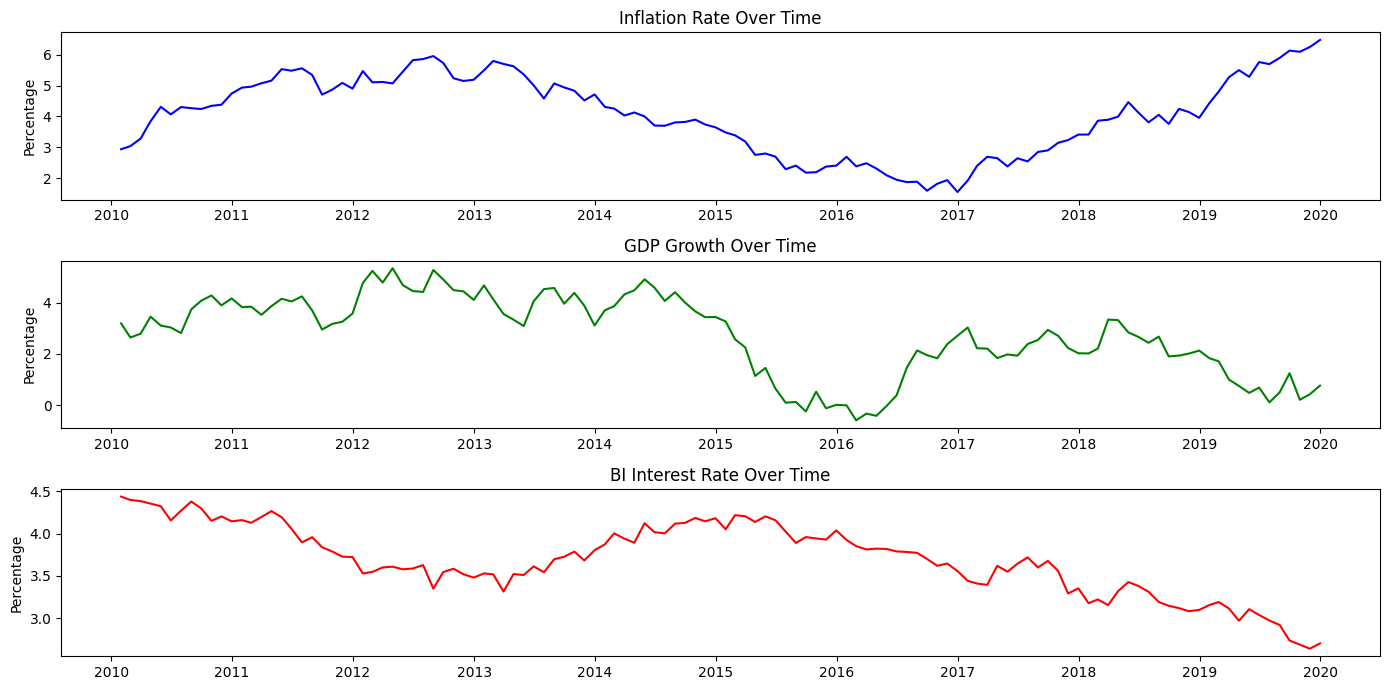

In [51]:
import numpy as np
import pandas as pd


# Generating dummy data for demonstration purposes
np.random.seed(0)  # For reproducibility

# Function to generate a random walk series
def generate_random_walk(start, periods, step_std):
    return np.cumsum(np.random.normal(scale=step_std, size=periods)) + start

# Define parameters for the dummy dataset
n_data = 120  # e.g., 10 years of monthly data
start_date = pd.Timestamp('2010-01-01')
end_date = start_date + pd.offsets.MonthEnd(n_data)

# Generate a date range
date_range = pd.date_range(start=start_date, end=end_date, freq='M')

# Generate dummy time series data
inflation_rate_series = generate_random_walk(start=2.5, periods=n_data, step_std=0.25)  # Start at 2.5%, small variance
gdp_growth_series = generate_random_walk(start=3.0, periods=n_data, step_std=0.5)  # Start at 3.0%, medium variance
bi_interest_rate_series = generate_random_walk(start=4.5, periods=n_data, step_std=0.1)  # Start at 4.5%, very small variance

# Create a DataFrame
dummy_data = pd.DataFrame({
    'Date': date_range,
    'Inflation_Rate': inflation_rate_series,
    'GDP_Growth': gdp_growth_series,
    'BI_Interest_Rate': bi_interest_rate_series
})

# Set the Date column as the index
dummy_data.set_index('Date', inplace=True)

# Plotting the dummy data
plt.figure(figsize=(14, 7))

plt.subplot(3, 1, 1)
plt.plot(dummy_data.index, dummy_data['Inflation_Rate'], label='Inflation Rate', color='blue')
plt.title('Inflation Rate Over Time')
plt.ylabel('Percentage')

plt.subplot(3, 1, 2)
plt.plot(dummy_data.index, dummy_data['GDP_Growth'], label='GDP Growth', color='green')
plt.title('GDP Growth Over Time')
plt.ylabel('Percentage')

plt.subplot(3, 1, 3)
plt.plot(dummy_data.index, dummy_data['BI_Interest_Rate'], label='BI Interest Rate', color='red')
plt.title('BI Interest Rate Over Time')
plt.ylabel('Percentage')

plt.tight_layout()
plt.show()

xlsx_path = 'dummy_economic_data.xlsx'
dummy_data.to_excel(xlsx_path)

Results of Dickey-Fuller Test:


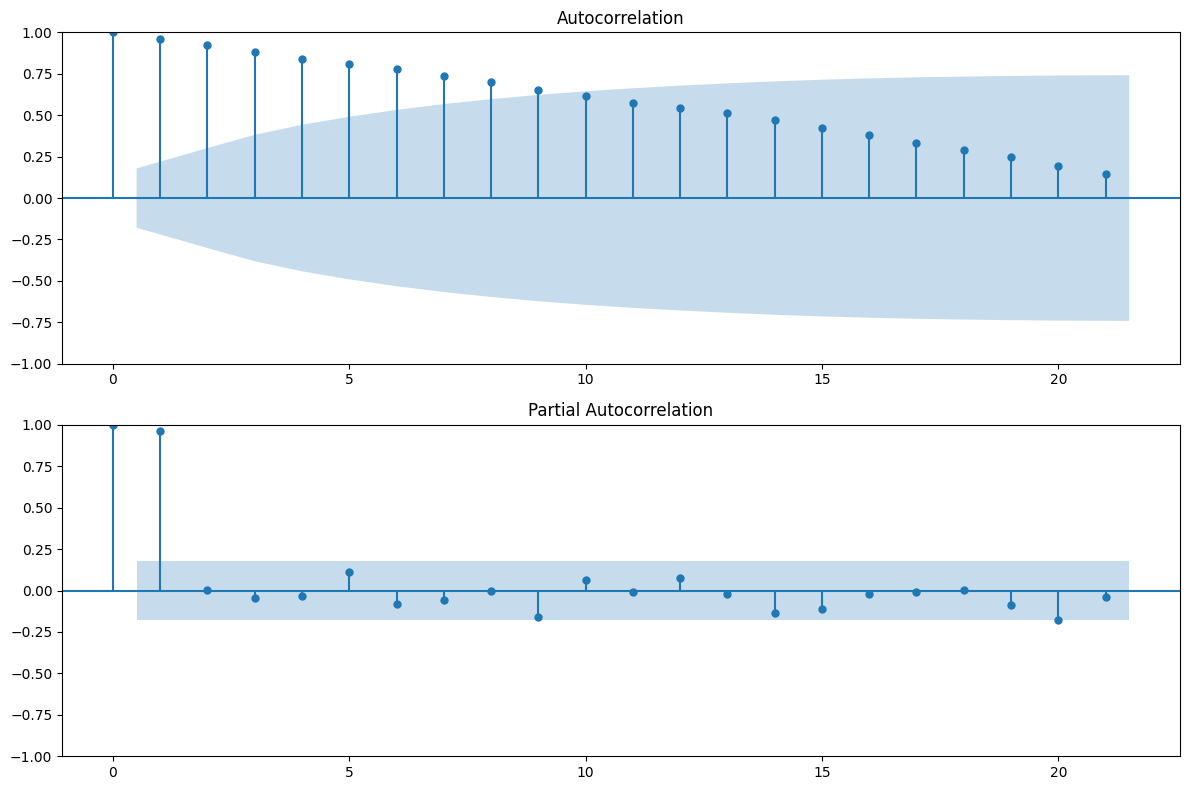

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


In [52]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Step 1: Check stationarity
def check_stationarity(timeseries):
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    return dfoutput

# Applying the function to the Inflation_Rate series
adf_test_result = check_stationarity(dummy_data['Inflation_Rate'])

# Step 2: Determine the order of ARIMA model
# We'll use ACF and PACF plots to estimate the ARIMA(p,d,q) parameters

# Plotting ACF and PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(dummy_data['Inflation_Rate'], ax=ax1)
plot_pacf(dummy_data['Inflation_Rate'], ax=ax2)
plt.tight_layout()
plt.show()

# For the sake of demonstration, let's assume ARIMA(1,1,1) could be a good starting point
# This is a common starting point and often needs to be refined based on model diagnostics

# Step 3: Fit ARIMA model
arima_order = (1, 1, 1)
model = ARIMA(dummy_data['Inflation_Rate'], order=arima_order)
model_fit = model.fit()



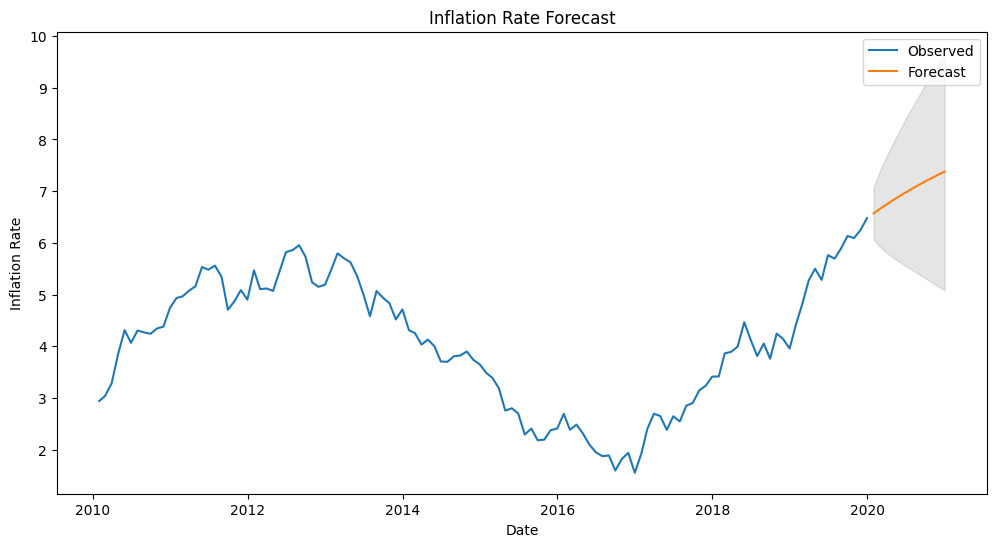

(<class 'statsmodels.iolib.summary.Summary'>
 """
                                SARIMAX Results                                
 Dep. Variable:         Inflation_Rate   No. Observations:                  120
 Model:                 ARIMA(1, 1, 1)   Log Likelihood                  -6.828
 Date:                Sun, 07 Apr 2024   AIC                             19.657
 Time:                        19:29:55   BIC                             27.994
 Sample:                    01-31-2010   HQIC                            23.042
                          - 12-31-2019                                         
 Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
 ------------------------------------------------------------------------------
 ar.L1          0.9650      0.054     18.025      0.000       0.860       1.070
 ma.L1         -0.9018      0.084    -10.678      0.000      -1.067   

In [53]:
# Step 4: Make predictions
# For demonstration, let's predict the next 12 periods (e.g., months)
forecast_periods = 12
forecast = model_fit.get_forecast(steps=forecast_periods)
forecast_index = pd.date_range(dummy_data.index[-1] + pd.offsets.MonthEnd(1), periods=forecast_periods, freq='M')

# Create a series for the forecast and the confidence interval
forecast_series = pd.Series(forecast.predicted_mean, index=forecast_index)
conf_int = forecast.conf_int()
lower_series = pd.Series(conf_int.iloc[:, 0], index=forecast_index)
upper_series = pd.Series(conf_int.iloc[:, 1], index=forecast_index)

# Plot the data and the forecast
plt.figure(figsize=(12, 6))
plt.plot(dummy_data.index, dummy_data['Inflation_Rate'], label='Observed')
plt.plot(forecast_series, label='Forecast')
plt.fill_between(forecast_index, lower_series, upper_series, color='k', alpha=0.1)
plt.title('Inflation Rate Forecast')
plt.xlabel('Date')
plt.ylabel('Inflation Rate')
plt.legend()
plt.show()


# Return the model summary and the forecast
(model_fit.summary(), forecast_series)